## Load Dataset

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from importlib import reload
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

In [3]:
# libgomp issue, must import n2 before torch
from n2 import HnswIndex

In [4]:
import sys

sys.path.insert(0, '..')

In [5]:
import os
home_dir = os.getenv('HOME')

https://dbs.uni-leipzig.de/research/projects/object_matching/benchmark_datasets_for_entity_resolution

In [6]:
import glob
import csv
from tqdm.auto import tqdm

row_dict = {}
rows_total = 2260

with tqdm(total=rows_total) as pbar:
    with open(f'{home_dir}/Downloads/affiliationstrings/affiliationstrings_ids.csv') as f:
        for row in csv.DictReader(f):
            row['id'] = int(row.pop('id1'))
            row_dict[row['id']] = row
            pbar.update(1)

FileNotFoundError: [Errno 2] No such file or directory: '/home/renato/Downloads/affiliationstrings/affiliationstrings_ids.csv'

In [ ]:
true_pair_set = set()

with open(f'{home_dir}/Downloads/affiliationstrings/affiliationstrings_mapping.csv') as f:
    for row in csv.DictReader(f, fieldnames=['id1', 'id2']):
        true_pair_set.add(tuple(sorted([int(row['id1']), int(row['id2'])])))

len(true_pair_set)

In [ ]:
from entity_embed.data_utils.utils import id_pairs_to_cluster_mapping_and_dict

cluster_mapping, cluster_dict = id_pairs_to_cluster_mapping_and_dict(true_pair_set)
len(cluster_mapping)

In [ ]:
len(cluster_dict)

In [ ]:
from entity_embed.data_utils.utils import cluster_dict_to_id_pairs

assert len(true_pair_set - cluster_dict_to_id_pairs(cluster_dict)) == 0

In [ ]:
cluster_attr = 'cluster_id'

for row_id, row in tqdm(row_dict.items()):
    row[cluster_attr] = cluster_mapping[row_id]

In [ ]:
row_dict[2727]

In [ ]:
[row_dict[row_id] for row_id in cluster_dict[row_dict[2727]['cluster_id']]]

## Preprocess

In [ ]:
attr_list = ['affil1']

In [ ]:
import unidecode
from entity_embed import default_tokenizer

def clean_str(s):
    s = unidecode.unidecode(s).lower().strip()
    return ' '.join(s_part for s_part in default_tokenizer(s))

for row in tqdm(row_dict.values()):
    for attr in attr_list:
        row[attr] = clean_str(row[attr])

## Init Data Module

In [ ]:
import torch
import numpy as np

random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

In [ ]:
alphabet = list('0123456789abcdefghijklmnopqrstuvwxyz!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ ')

In [ ]:
attr_info_dict = {
    'affil1': {
        'field_type': "SEMANTIC_MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'vocab': "fasttext.en.300d",
        'use_mask': True,
    }
}

In [ ]:
from entity_embed.data_utils.helpers import AttrInfoDictParser

row_numericalizer = AttrInfoDictParser.from_dict(attr_info_dict, row_dict=row_dict)
row_numericalizer.attr_info_dict

In [ ]:
from entity_embed import DeduplicationDataModule

train_cluster_len = 100
valid_cluster_len = 100
test_cluster_len = len(cluster_dict) - valid_cluster_len - train_cluster_len
datamodule = DeduplicationDataModule(
    row_dict=row_dict,
    cluster_attr=cluster_attr,
    row_numericalizer=row_numericalizer,
    pos_pair_batch_size=45,
    neg_pair_batch_size=1225,
    row_batch_size=16,
    train_cluster_len=train_cluster_len,
    valid_cluster_len=valid_cluster_len,
    test_cluster_len=test_cluster_len,
    only_plural_clusters=True,
    random_seed=random_seed
)

## Training

In [ ]:
from entity_embed import EntityEmbed

ann_k = 100
model = EntityEmbed(
    datamodule,
    ann_k=ann_k,
    embedding_size=300,
)

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

max_epochs = 50
early_stop_callback = EarlyStopping(
   monitor='valid_recall_at_0.3',
   min_delta=0.00,
   patience=10,
   verbose=True,
   mode='max'
)
tb_log_dir = 'tb_logs'
tb_name = 'affiliations'
trainer = pl.Trainer(
    gpus=1,
    max_epochs=max_epochs,
    check_val_every_n_epoch=1,
    callbacks=[early_stop_callback],
    logger=TensorBoardLogger(tb_log_dir, name=tb_name)
)

In [ ]:
trainer.fit(model, datamodule)

In [ ]:
import gc
del trainer
gc.collect()

## Testing manually 

In [ ]:
datamodule.setup(stage='test')

In [ ]:
test_row_dict = datamodule.test_row_dict
test_vector_dict = model.predict(
    row_dict=test_row_dict,
    batch_size=16
)

In [ ]:
embedding_size = model.blocker_net.embedding_size
test_true_pair_set = datamodule.test_true_pair_set

In [ ]:
import gc
del model
del datamodule
gc.collect()

In [ ]:
assert len(test_vector_dict) == len(test_row_dict)

In [ ]:
%%time

from entity_embed import ANNEntityIndex

ann_index = ANNEntityIndex(embedding_size=embedding_size)
ann_index.insert_vector_dict(test_vector_dict)
ann_index.build()

In [ ]:
%%time

sim_threshold = 0.3
found_pair_set = ann_index.search_pairs(
    k=ann_k,
    sim_threshold=sim_threshold
)

In [ ]:
from entity_embed.evaluation import pair_entity_ratio

pair_entity_ratio(len(found_pair_set), len(test_row_dict))

In [ ]:
from entity_embed.evaluation import precision_and_recall

precision_and_recall(found_pair_set, test_true_pair_set)

In [ ]:
false_positives = list(found_pair_set - test_true_pair_set)
len(false_positives)

In [ ]:
false_negatives = list(test_true_pair_set - found_pair_set)
len(false_negatives)

In [ ]:
cos_similarity = lambda a, b: np.dot(a, b)

In [ ]:
for (id_left, id_right) in false_negatives[:10]:
    display(
        (
            cos_similarity(test_vector_dict[id_left], test_vector_dict[id_right]),
            row_dict[id_left], row_dict[id_right]
        )
    )

## t-sne visualization

In [106]:
vis_sample_size = 10

In [107]:
from entity_embed.data_utils.utils import row_dict_to_cluster_dict

test_cluster_dict = row_dict_to_cluster_dict(test_row_dict, cluster_attr)
vis_cluster_dict = dict(sorted(test_cluster_dict.items(), key=lambda x: len(x[1]), reverse=True)[:vis_sample_size])

In [108]:
vis_x = np.stack([test_vector_dict[id_] for cluster in vis_cluster_dict.values() for id_ in cluster])
vis_y = [test_row_dict[cluster[0]]['affil1'] for cluster_id, cluster in vis_cluster_dict.items() for id_ in cluster]

In [121]:
from sklearn.manifold import TSNE

tnse = TSNE(metric='cosine', perplexity=20, random_state=random_seed)
tsne_results = tnse.fit_transform(vis_x)

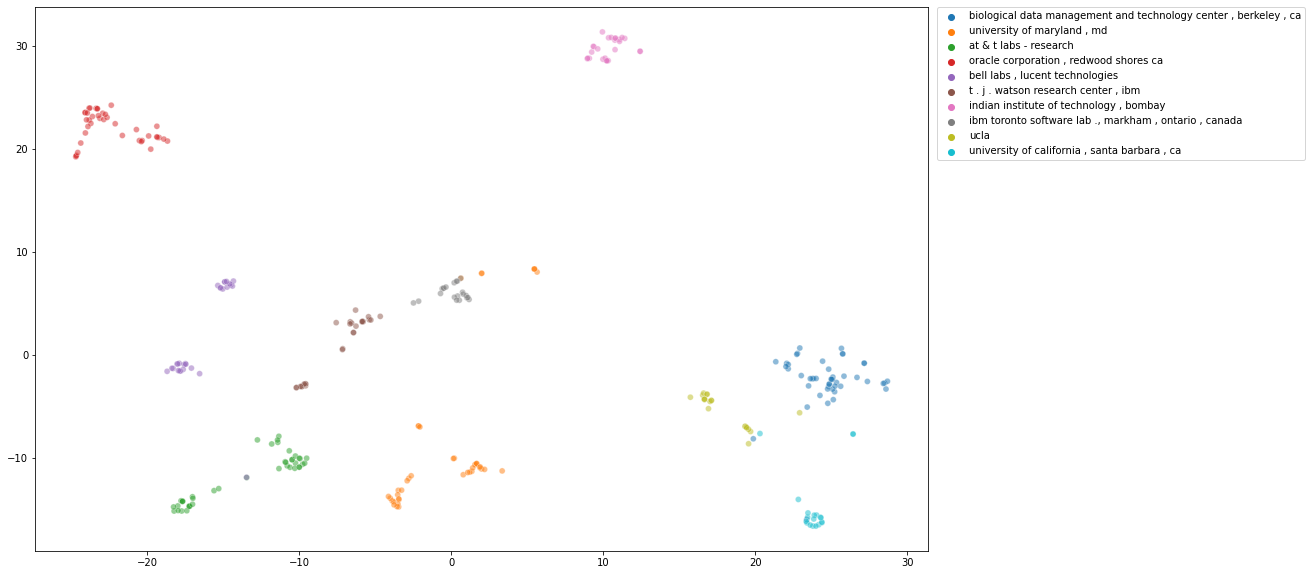

In [122]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

plt.figure(figsize=(16,10))
ax = sns.scatterplot(
    x=tsne_results[:,0],
    y=tsne_results[:,1],
    hue=vis_y,
    palette=sns.color_palette("tab10", len(vis_cluster_dict.keys())),
    legend="full",
    alpha=0.5,
)
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.);